# SVM Method : EMU-Fight

This notebook shows the emulation of the two point correlation functions using Suport Vector Machine (SVM).

SVM is a supervised learning algorithm that can be employed in classification and regression tasks. In particular, in this notebook uses SVM for regression analysis purposes. 

The Support Vector Regression (SVR) uses the same principles as the SVM for classification, with only a few minor differences. A margin is defined not to separate between two classes but instead is used to define the region of intereset ($\epsilon$).

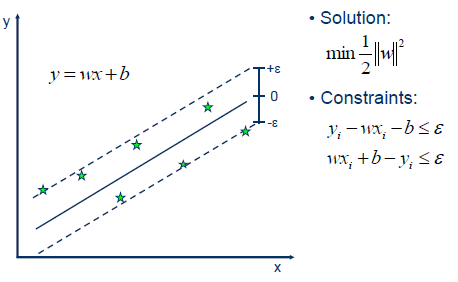

The main idea is: to minimize error, individualizing the hyperplane which maximizes the margin, keeping in mind that part of the error is tolerated.  

Usually, SVM is better in small sample than the other methods.

for more information: https://www.saedsayad.com/support_vector_machine_reg.htm

#### Index<a name="index"></a>
1. [Import packages](#imports)
* [Load data](#loadData)
 1. [Load train data](#loadTrainData)
 * [Load test data](#loadTestData)
1. [Visualiazing the dataset](#visualization)
* [Emulator method](#emulator)

## 1. Import packages<a name="imports"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

## 2. Load data<a name="loadData"></a>

Read the training data from a `.npy` file:

### 2.1. Load train data<a name="loadTrainData"></a>

In [122]:
import pandas as pd

df = pd.read_pickle('../data/cosmology_train.pickle')

The cosmology dataset contains cosmological parameters (Omega_m, sigma8, Omega_b) as inputs, and the correlation function as output. The correlation function is measured at 10 separation values $r$.

### 2.2. Load test data<a name="loadTestData"></a>

In [123]:
df_test = pd.read_pickle('../data/cosmology_test.pickle')

## 3. Visualiazing the dataset<a name="visualization"></a>

#### 3.1 Data Structure: Pickle, Pandas DataFrame

The cosmology dataset contains cosmological parameters (Omega_m, sigma8, Omega_b) as inputs, and the correlation function as output. The correlation function is measured at 10 separation values  𝑟 .

In [124]:
df_in = df['input_data']
df_in

,object_id,$\Omega_m$,$\sigma_8$,$\Omega_b$
0,obj_0,0.26,0.70,0.038000
1,obj_1,0.26,0.70,0.040222
2,obj_2,0.26,0.70,0.042444
3,obj_3,0.26,0.70,0.044667
4,obj_4,0.26,0.70,0.046889
...,...,...,...,...
995,obj_995,0.34,0.95,0.049111
996,obj_996,0.34,0.95,0.051333
997,obj_997,0.34,0.95,0.053556
998,obj_998,0.34,0.95,0.055778


In [125]:
df_out = df['output_data']
df_out

,object_id,$\xi(r_0)$,$\xi(r_1)$,$\xi(r_2)$,$\xi(r_3)$,$\xi(r_4)$,$\xi(r_5)$,$\xi(r_6)$,$\xi(r_7)$,$\xi(r_8)$,$\xi(r_9)$
0,obj_0,0.007281,0.003812,0.002051,0.001160,0.000831,0.001003,0.001137,0.000513,-0.000027,-0.000187
1,obj_1,0.007542,0.003979,0.002163,0.001243,0.000921,0.001147,0.001256,0.000514,-0.000045,-0.000197
2,obj_2,0.007814,0.004154,0.002280,0.001333,0.001020,0.001304,0.001372,0.000508,-0.000063,-0.000205
3,obj_3,0.008096,0.004337,0.002404,0.001428,0.001129,0.001476,0.001484,0.000498,-0.000079,-0.000213
4,obj_4,0.008390,0.004528,0.002535,0.001531,0.001248,0.001663,0.001589,0.000483,-0.000094,-0.000220
...,...,...,...,...,...,...,...,...,...,...,...
995,obj_995,0.007447,0.003445,0.001619,0.000890,0.001226,0.001696,0.000305,-0.000405,-0.000442,-0.000374
996,obj_996,0.007723,0.003614,0.001729,0.000987,0.001408,0.001829,0.000261,-0.000429,-0.000450,-0.000382
997,obj_997,0.008009,0.003791,0.001846,0.001093,0.001606,0.001952,0.000214,-0.000450,-0.000459,-0.000390
998,obj_998,0.008305,0.003974,0.001968,0.001208,0.001821,0.002063,0.000165,-0.000469,-0.000467,-0.000398


In [126]:
rvals = df['extra_input']['r_vals']
rvals

array([ 50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140.])

#### 3.3 Defining variables

In [127]:
df_out.columns

Index(['object_id', '$\xi(r_0)$', '$\xi(r_1)$', '$\xi(r_2)$', '$\xi(r_3)$',
       '$\xi(r_4)$', '$\xi(r_5)$', '$\xi(r_6)$', '$\xi(r_7)$', '$\xi(r_8)$',
       '$\xi(r_9)$'],
      dtype='object')

In [128]:
df_in.columns

Index(['object_id', '$\Omega_m$', '$\sigma_8$', '$\Omega_b$'], dtype='object')

In [129]:
ys_train = df_out[[r'$\xi(r_0)$', r'$\xi(r_1)$', r'$\xi(r_2)$', r'$\xi(r_3)$',
       r'$\xi(r_4)$', r'$\xi(r_5)$', r'$\xi(r_6)$', r'$\xi(r_7)$', r'$\xi(r_8)$',
       r'$\xi(r_9)$']].to_numpy()

xs_train = df_in[[r'$\Omega_m$', r'$\sigma_8$', r'$\Omega_b$']].to_numpy()

In [130]:
print('x shape:',xs_train.shape)
print('y shape:',ys_train.shape)

x shape: (1000, 3)
y shape: (1000, 10)


#### 3.3 Visualizing the dataset

Text(0, 0.5, '$\\xi(r)$')

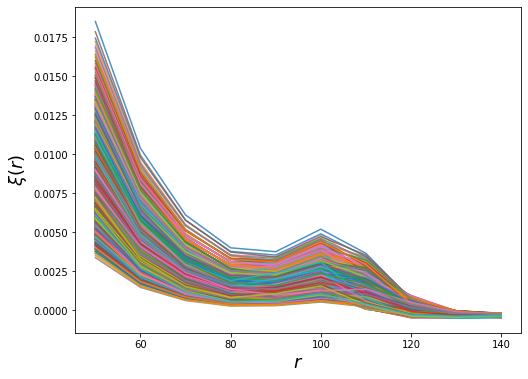

In [131]:
plt.figure(figsize=(8,6))
ys_train_plot = ys_train.copy()
np.random.shuffle(ys_train_plot) # shuffle so that color order isn't weird
plt.plot(rvals, ys_train_plot.T, alpha=0.8)

plt.xlabel('$r$',fontsize=18)
plt.ylabel(r'$\xi(r)$',fontsize=18)

# plt.xscale('log')
# plt.yscale('log')


Let's do the same for our test set:

In [132]:
df_test_in = df_test['input_data']
df_test_out = df_test['output_data']

ys_test = df_test_out[[r'$\xi(r_0)$', r'$\xi(r_1)$', r'$\xi(r_2)$', r'$\xi(r_3)$',
       r'$\xi(r_4)$', r'$\xi(r_5)$', r'$\xi(r_6)$', r'$\xi(r_7)$', r'$\xi(r_8)$',
       r'$\xi(r_9)$']].to_numpy()

xs_test = df_test_in[[r'$\Omega_m$', r'$\sigma_8$', r'$\Omega_b$']].to_numpy()

In [133]:
n_test = xs_test.shape[0]
n_values= ys_test.shape[1]
n_params= xs_test.shape[1]
print("Number of datapoints:", n_test)
print("Number of input parameters:", n_params)
print("Number of output values:", n_values)

Number of datapoints: 100
Number of input parameters: 3
Number of output values: 10


Text(0, 0.5, '$\\xi(r)$')

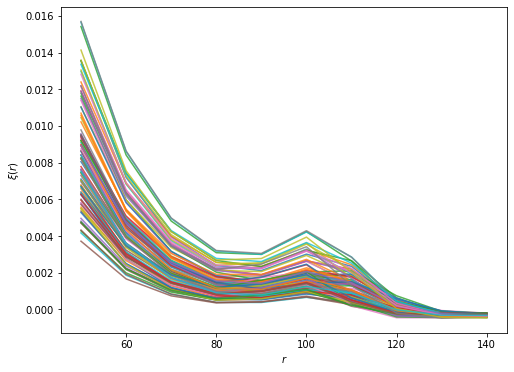

In [134]:
plt.figure(figsize=(8,6))
plt.plot(rvals, ys_test.T, alpha=0.8)
plt.xlabel('$r$')
plt.ylabel(r'$\xi(r)$')

## 4. Emulator method<a name="emulator"></a>

SVM Method

based on this example: https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py

In [135]:
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

# #############################################################################
# sample data
X = xs_train
y = ys_train

Xt= xs_test

# #############################################################################
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.01, degree=10)
svr_lin = SVR(kernel='linear', C=100, gamma='auto', epsilon=.1)
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=12, epsilon=.1,
               coef0=1)
##############################################################################

In [136]:
svr_rbf

SVR(C=100, cache_size=200, coef0=0.0, degree=10, epsilon=0.01, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [137]:
print(X.shape)
print(y.shape)

(1000, 3)
(1000, 10)


In [138]:
scaler = StandardScaler()
scaler.fit(xs_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [139]:
xs_train = scaler.transform(xs_train)
xs_test = scaler.transform(xs_test)

y_mean = np.mean(ys_train, axis=0)
ys_train = ys_train/y_mean
ys_test = ys_test/y_mean

In [140]:
def do_regresssion(kwargs):
    regrs = np.empty(n_values, dtype=object)
    scores= np.empty(n_values, dtype=object)
    for j in range(n_values):
        ys_train_r = ys_train[:,j]
        ys_test_r = ys_test[:,j]
        regr = SVR(**kwargs).fit(xs_train, ys_train_r)
        score = regr.score(xs_test, ys_test_r)
        print(f"Value {j} score:", score)
        regrs[j] = regr
        scores[j] = score
    print()
    return regrs, scores

In [115]:
kwargs = {'kernel':'rbf', 'epsilon':5e-4, 'C':11, 'gamma':0.09,'tol':1e-6}
r,s = do_regresssion(kwargs)

Value 0 score: 0.9999991809321379
Value 1 score: 0.9999992895722101
Value 2 score: 0.999999350501448
Value 3 score: 0.9999994331929396
Value 4 score: 0.9999993975811575
Value 5 score: 0.9999993881147857
Value 6 score: 0.9999995750821941
Value 7 score: 0.9999862292759384
Value 8 score: 0.999998705844351
Value 9 score: 0.9999981548219555



In [116]:
regrs = r

In [117]:
ys_predict = np.zeros((n_test, n_values))
for j in range(n_values):  
    ys_predict_r = regrs[j].predict(xs_test)
    ys_predict[:,j] = ys_predict_r

In [118]:
n_plot = int(0.2*n_test)
idxs = np.random.choice(np.arange(n_test), n_plot)
color_idx = np.linspace(0, 1, n_plot)
colors = np.array([plt.cm.rainbow(c) for c in color_idx])

In [119]:
ys_train = ys_train*y_mean
ys_test = ys_test*y_mean
ys_predict = ys_predict*y_mean

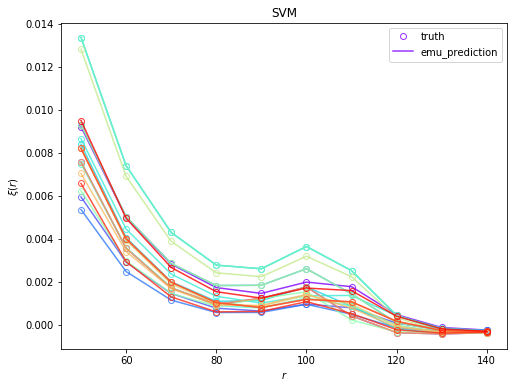

In [120]:
plt.figure(figsize=(8,6))
for i in range(n_plot):
    ys_test_plot = ys_test[idxs,:][i]
    ys_predict_plot = ys_predict[idxs][i]
    if i==0:
        label_test = 'truth'
        label_predict = 'emu_prediction'
    else:
        label_test = None
        label_predict = None
    plt.plot(rvals[:n_values], ys_test_plot, alpha=0.8, label=label_test, marker='o', markerfacecolor='None', ls='None', color=colors[i])
    plt.plot(rvals[:n_values], ys_predict_plot, alpha=0.8, label=label_predict, color=colors[i])
plt.xlabel('$r$')
plt.ylabel(r'$\xi(r)$')
plt.title('SVM')
plt.legend()

Text(0, 0.5, 'fractional error')

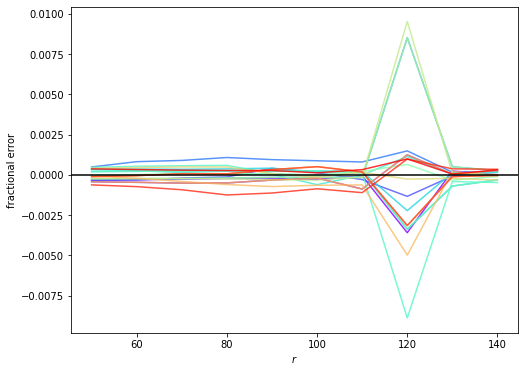

In [121]:
plt.figure(figsize=(8,6))
for i in range(n_plot):
    ys_test_plot = ys_test[idxs,:][i]
    ys_predict_plot = ys_predict[idxs][i]
    frac_err = (ys_predict_plot-ys_test_plot)/ys_test_plot
    plt.plot(rvals, frac_err, alpha=0.8, color=colors[i])
plt.axhline(0.0, color='k')
plt.xlabel('$r$')
plt.ylabel(r'fractional error')

#### 3.3 Grid Params

In [113]:
ys_train = ys_train/y_mean
ys_test = ys_test/y_mean

#### Which kernel is best?

In [143]:
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

scoring = make_scorer(r2_score)
param_grid = [{'kernel': ['linear'], 'gamma': [7e-2,9e-2,11e-2],
               'C': [ 1, 7, 10], 'epsilon':[1e-3,1e-4]},
             {'kernel': ['poly'], 'gamma': [7e-2,9e-2,11e-2],
               'C': [ 1, 7, 10], 'epsilon':[1e-3,1e-4]},
             {'kernel': ['rbf'], 'gamma': [7e-2,9e-2,11e-2],
               'C': [ 1, 7, 10], 'epsilon':[1e-3,1e-4]}]

# param_grid = [{'kernel': ['rbf'], 'gamma': [7e-2,9e-2,11e-2],
#                'C': [ 1, 3, 7, 10]}]

g_cv = GridSearchCV(SVR(), param_grid, scoring=scoring, refit=True, cv=10)
g_cv.fit(xs_train, ys_train[:,7])
score = r2_score(ys_test[:,7], g_cv.predict(xs_test))

print("Best parameters set found on development set:")
print()
print('%.5f'%score,':',g_cv.best_params_)
print()
print()
print("Grid scores on development set:")
print()
means = g_cv.cv_results_['mean_test_score']
stds = g_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, g_cv.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Best parameters set found on development set:

0.9999 : {'C': 10, 'epsilon': 0.0001, 'gamma': 0.11, 'kernel': 'rbf'}


Grid scores on development set:

0.871 (+/-0.071) for {'C': 1, 'epsilon': 0.001, 'gamma': 0.07, 'kernel': 'linear'}
0.871 (+/-0.071) for {'C': 1, 'epsilon': 0.001, 'gamma': 0.09, 'kernel': 'linear'}
0.871 (+/-0.071) for {'C': 1, 'epsilon': 0.001, 'gamma': 0.11, 'kernel': 'linear'}
0.871 (+/-0.071) for {'C': 1, 'epsilon': 0.0001, 'gamma': 0.07, 'kernel': 'linear'}
0.871 (+/-0.071) for {'C': 1, 'epsilon': 0.0001, 'gamma': 0.09, 'kernel': 'linear'}
0.871 (+/-0.071) for {'C': 1, 'epsilon': 0.0001, 'gamma': 0.11, 'kernel': 'linear'}
0.871 (+/-0.072) for {'C': 7, 'epsilon': 0.001, 'gamma': 0.07, 'kernel': 'linear'}
0.871 (+/-0.072) for {'C': 7, 'epsilon': 0.001, 'gamma': 0.09, 'kernel': 'linear'}
0.871 (+/-0.072) for {'C': 7, 'epsilon': 0.001, 'gamma': 0.11, 'kernel': 'linear'}
0.870 (+/-0.072) for {'C': 7, 'epsilon': 0.0001, 'gamma': 0.07, 'kernel': 'linear'}
0.870 (+/-0.07

#### Which kernel is best?
Answer: rbf, then linear and poly

#### What is the best setup for all bins?

In [144]:
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

scoring = make_scorer(r2_score)
param_grid = [{'kernel': ['rbf'], 'gamma': [5e-2,7e-2,9e-2],
               'C': [ 7, 10, 13, 20], 'epsilon':[5e-4,1e-4,5-4]}]

print("Best parameters set found on development set:")
for ix in range(n_values):
    g_cv = GridSearchCV(SVR(), param_grid, scoring=scoring, refit=True, cv=10)
    g_cv.fit(xs_train, ys_train[:,ix])
    score = r2_score(ys_test[:,ix], g_cv.predict(xs_test))
    print()
    print('radii bin %i'%ix)
    print('%.4f'%score,':',g_cv.best_params_)
    print()

Best parameters set found on development set:

radii bin 0
1.0000 : {'C': 20, 'epsilon': 0.0001, 'gamma': 0.05, 'kernel': 'rbf'}



KeyboardInterrupt: 

It's best to use a mean value of the parameters: epsilon=0.05;
gamma = 0.09;
C = 7

In [ ]:
# from sklearn.metrics import make_scorer
# from sklearn.metrics import r2_score
# from sklearn.model_selection import GridSearchCV

# scoring = make_scorer(r2_score)
# param_grid = [{'kernel': ['rbf'], 'gamma': [7e-2,9e-2,11e-2],
#                'epsilon': [ 1e-4, 5e-4, 1e-3, 5e-2]}]

# print("Best parameters set found on development set:")
# for ix in range(n_values):
#     g_cv = GridSearchCV(SVR(), param_grid, scoring=scoring, refit=True, cv=10)
#     g_cv.fit(xs_train, ys_train[:,ix])
#     score = r2_score(ys_test[:,ix], g_cv.predict(xs_test))
#     print()
#     print('radii bin %i'%ix)
#     print('%.4f'%score,':',g_cv.best_params_)
#     print()